## Creation of knockoffs from Spec2Vec embeddings


load files with spectra, put your own path

In [10]:
import numpy as np
import os
import sys
from matchms.importing import load_from_json
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

folder_name = 'C:\\Users\\Gosia\\Desktop'
json_file_name = os.path.join(folder_name,'FDR-datsets', 'specs.json')
sys.path.append(os.path.join(folder_name,'FDR-Metabolomics', 'src'))


In [11]:
spectrums = load_from_json(json_file_name)
spectrums = [s for s in spectrums if s.metadata.get('inchikey')]
print(len(spectrums))


31147
31147


In [12]:
# Remove duplicate spectra
specs_by_peaks = {}
for s in spectrums:
    specs_by_peaks[tuple(p for ps in s.peaks for p in ps)] = s

In [13]:
print(len(specs_by_peaks))

30379
30379


In [14]:
spectrums = list(specs_by_peaks.values())

Creating a mapping of the inchi key prefixes to the spectrums in order to identify matching spectra

In [15]:
inchi_dict = {}
for s in spectrums:
    ik = s.metadata['inchikey']
    init_ik = ik.split('-')[0]
    if not init_ik in inchi_dict:
        inchi_dict[init_ik] = [s]
    else:
        inchi_dict[init_ik].append(s)

Dividing the spectra into library and queries

In [16]:
query_size = 1000

Building the library with matching queries plus noise

In [17]:
# choosing queries from multis ensures a possible true match
multis = set([i for i,v in inchi_dict.items() if len(v) > 1])

matching_keys = np.random.choice(list(multis), size=query_size, replace=False)

query_spec = {}
spectrums_lib = []
# We select query_size queries that have at least 1 matching spectrum in the library
for q in matching_keys:
    spec_to_add = np.random.choice(inchi_dict[q], size=1, replace=False)
    query_spec[spec_to_add[0].metadata['spectrum_id']] = spec_to_add[0]

# And everything else goes into the library
for s in spectrums:
    if s.metadata['spectrum_id'] not in query_spec:
        spectrums_lib.append(s)

spectrums_query = list(query_spec.values())

Create spectrum "documents"

In [18]:
documents_query = [SpectrumDocument(s, n_decimals=2) for s in spectrums_query]
documents_lib = [SpectrumDocument(s, n_decimals=2) for s in spectrums_lib]


Load pretrained model

In [19]:
import gensim
model_file = os.path.join('C:\\Users\\Gosia\\Desktop\\trained_models_1\\spec2vec_size_170.model')
model = gensim.models.Word2Vec.load(model_file)


In [20]:
from cosine_calc import get_hits

allowed_missing_percentage = 15
intensity_weighting_power = 0.5

hits = get_hits(documents_query, documents_lib, spec2vec_model=model,
                intensity_weighting_power=intensity_weighting_power,
                allowed_missing_percentage=allowed_missing_percentage, passatutto=False)

In [21]:
# Calculating true q-value scores
from q_value_calc import calculate_q_value
q_list_true = calculate_q_value(hits)

## Creation of knockoffs

In [ ]:
from knockoffs import generate_knockoffs

#diags = [30,50,70,100]
diags = [5,20]
q_list_knockoffs = {}
for diag in diags:
    for comp in [5,7]:#,10,15]:
        try:
            knockoff_documents = generate_knockoffs(model,documents_lib,allowed_missing_percentage=allowed_missing_percentage,n_components=comp, diagonal_matrix=diag)
            hits_knockoffs = get_hits(documents_query, knockoff_documents, decoys=True, spec2vec_model=model, precursor_tol=3,
                                                                    intensity_weighting_power=intensity_weighting_power,
                                                                    allowed_missing_percentage=allowed_missing_percentage, passatutto=False)
            q_list_knockoffs[(diag, comp)] = calculate_q_value(hits+hits_knockoffs,True)
        except Exception as e:
            print( diag, "failed", e )

Embedding vector size: 170
Embedding vector size: 170
Embedding vector size: 170
Embedding vector size: 170


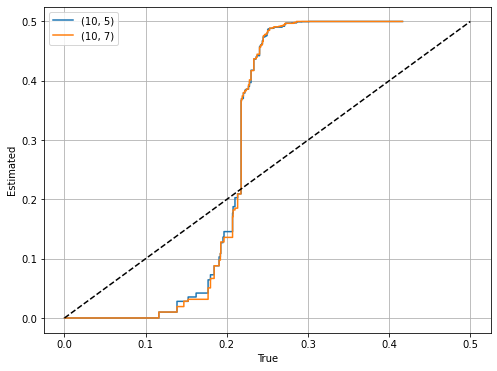

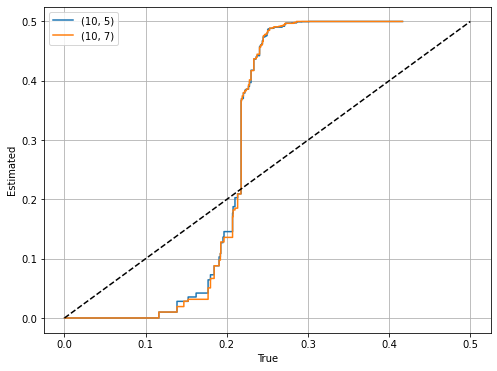

In [39]:
import plot_q_vals

# plot estimated and true q-values
def combine_true_est(q_val_true,q_val_est):
    res = []
    q_idx = 0
    for q_e, _, score in q_val_est:
        while q_idx < len(q_val_true)-1 and q_val_true[q_idx+1][2] >= score:
            q_idx += 1
        res.append((score, q_val_true[q_idx][0], q_e))
    return res
        
to_plot = {}
for k,v in q_list_knockoffs.items():
    to_plot[k] = list(zip(*combine_true_est(q_list_true, v)))[1], list(zip(*combine_true_est(q_list_true, v)))[2]
plot_q_vals.plot_q_vals( to_plot )

In [32]:
hits_sorted = sorted(hits, key=lambda h:h.score, reverse=True)
for i, h in enumerate( hits_sorted[:20] ):
    if not h.hit:
        print(i)

10
10


In [33]:
hits_sorted = sorted(hits, key=lambda h:h.score, reverse=True)
for i, h in enumerate( hits_sorted[:20] ):
    if not h.hit:
        print(i)

10
10


In [34]:
hit = hits_sorted[5]
from pprint import pprint
#pprint(hit.query._obj.metadata)
pprint([p for p in hit.query._obj.peaks])

[array([ 71.0509,  83.0502,  85.0295, 111.0448, 129.0553, 147.0658,
       153.0541, 171.0656, 239.0923, 257.1018, 275.1136, 287.0555,
       288.0581, 293.1229, 433.1141, 434.1191, 579.1735, 725.2292]),
 array([0.12105263, 0.07260062, 0.2493808 , 0.08106295, 0.15128999,
       0.04407121, 0.0400774 , 0.0219453 , 0.12244582, 0.03206398,
       0.03317337, 1.        , 0.04852941, 0.02020124, 0.61816305,
       0.03566563, 0.06480908, 0.14365325])]
[array([ 71.0509,  83.0502,  85.0295, 111.0448, 129.0553, 147.0658,
       153.0541, 171.0656, 239.0923, 257.1018, 275.1136, 287.0555,
       288.0581, 293.1229, 433.1141, 434.1191, 579.1735, 725.2292]),
 array([0.12105263, 0.07260062, 0.2493808 , 0.08106295, 0.15128999,
       0.04407121, 0.0400774 , 0.0219453 , 0.12244582, 0.03206398,
       0.03317337, 1.        , 0.04852941, 0.02020124, 0.61816305,
       0.03566563, 0.06480908, 0.14365325])]


In [35]:
#pprint(hit.target._obj.metadata)
pprint([p for p in hit.target._obj.peaks])

[array([ 71.050903,  83.050201,  85.029503, 111.0448  , 129.055298,
       147.065796, 153.054092, 171.065598, 239.0923  , 257.101807,
       275.113586, 287.055511, 288.058105, 293.122894, 433.114105,
       434.11911 , 579.173523, 725.229187]),
 array([0.12012012, 0.07207207, 0.24924925, 0.08008008, 0.15115115,
       0.04404404, 0.04004004, 0.02102102, 0.12212212, 0.03203203,
       0.03303303, 1.        , 0.04804805, 0.02002002, 0.61761762,
       0.03503504, 0.06406406, 0.14314314])]
[array([ 71.050903,  83.050201,  85.029503, 111.0448  , 129.055298,
       147.065796, 153.054092, 171.065598, 239.0923  , 257.101807,
       275.113586, 287.055511, 288.058105, 293.122894, 433.114105,
       434.11911 , 579.173523, 725.229187]),
 array([0.12012012, 0.07207207, 0.24924925, 0.08008008, 0.15115115,
       0.04404404, 0.04004004, 0.02102102, 0.12212212, 0.03203203,
       0.03303303, 1.        , 0.04804805, 0.02002002, 0.61761762,
       0.03503504, 0.06406406, 0.14314314])]


In [36]:
q_list_true

[(0, True, 0.9999999999999998),
 (0.0, True, 0.9999997983820432),
 (0.0, True, 0.9999997704482645),
 (0.0, True, 0.9999993289072289),
 (0.0, True, 0.9999967850467398),
 (0.0, True, 0.9999963225145738),
 (0.0, True, 0.9999957337361818),
 (0.0, True, 0.9999951586831917),
 (0.0, True, 0.999994347305656),
 (0.0, True, 0.9999930832421582),
 (0.03636363636363636, False, 0.9999859224188686),
 (0.03636363636363636, True, 0.9999831438172677),
 (0.03636363636363636, True, 0.9999806930248368),
 (0.03636363636363636, True, 0.9999761982321185),
 (0.03636363636363636, True, 0.9999758047931255),
 (0.03636363636363636, True, 0.9999666212497146),
 (0.03636363636363636, True, 0.9999513460453446),
 (0.03636363636363636, True, 0.9999409901585957),
 (0.03636363636363636, True, 0.9999342003601496),
 (0.03636363636363636, True, 0.9999275591877238),
 (0.03636363636363636, True, 0.9999069812027912),
 (0.03636363636363636, True, 0.9999001561863858),
 (0.03636363636363636, True, 0.9999000343417956),
 (0.03636363

[(0, True, 0.9999999999999998),
 (0.0, True, 0.9999997983820432),
 (0.0, True, 0.9999997704482645),
 (0.0, True, 0.9999993289072289),
 (0.0, True, 0.9999967850467398),
 (0.0, True, 0.9999963225145738),
 (0.0, True, 0.9999957337361818),
 (0.0, True, 0.9999951586831917),
 (0.0, True, 0.999994347305656),
 (0.0, True, 0.9999930832421582),
 (0.03636363636363636, False, 0.9999859224188686),
 (0.03636363636363636, True, 0.9999831438172677),
 (0.03636363636363636, True, 0.9999806930248368),
 (0.03636363636363636, True, 0.9999761982321185),
 (0.03636363636363636, True, 0.9999758047931255),
 (0.03636363636363636, True, 0.9999666212497146),
 (0.03636363636363636, True, 0.9999513460453446),
 (0.03636363636363636, True, 0.9999409901585957),
 (0.03636363636363636, True, 0.9999342003601496),
 (0.03636363636363636, True, 0.9999275591877238),
 (0.03636363636363636, True, 0.9999069812027912),
 (0.03636363636363636, True, 0.9999001561863858),
 (0.03636363636363636, True, 0.9999000343417956),
 (0.03636363

In [37]:
list(q_list_knockoffs.values())[0]

[(0, True, 0.9999999999999998),
 (0.0, True, 0.9999997983820432),
 (0.0, True, 0.9999997704482645),
 (0.0, True, 0.9999993289072289),
 (0.0, True, 0.9999967850467398),
 (0.0, True, 0.9999963225145738),
 (0.0, True, 0.9999957337361818),
 (0.0, True, 0.9999951586831917),
 (0.0, True, 0.999994347305656),
 (0.0, True, 0.9999930832421582),
 (0.0, False, 0.9999859224188686),
 (0.0, True, 0.9999831438172677),
 (0.0, True, 0.9999806930248368),
 (0.0, True, 0.9999761982321185),
 (0.0, True, 0.9999758047931255),
 (0.0, True, 0.9999666212497146),
 (0.0, True, 0.9999513460453446),
 (0.0, True, 0.9999409901585957),
 (0.0, True, 0.9999342003601496),
 (0.0, True, 0.9999275591877238),
 (0.0, True, 0.9999069812027912),
 (0.0, True, 0.9999001561863858),
 (0.0, True, 0.9999000343417956),
 (0.0, True, 0.9998993435504305),
 (0.0, True, 0.9998958102094359),
 (0.0, True, 0.9998863223323969),
 (0.0, False, 0.9998808441267344),
 (0.0, True, 0.999870111813324),
 (0.0, True, 0.9998581480728032),
 (0.0, True, 0.9

[(0, True, 0.9999999999999998),
 (0.0, True, 0.9999997983820432),
 (0.0, True, 0.9999997704482645),
 (0.0, True, 0.9999993289072289),
 (0.0, True, 0.9999967850467398),
 (0.0, True, 0.9999963225145738),
 (0.0, True, 0.9999957337361818),
 (0.0, True, 0.9999951586831917),
 (0.0, True, 0.999994347305656),
 (0.0, True, 0.9999930832421582),
 (0.0, False, 0.9999859224188686),
 (0.0, True, 0.9999831438172677),
 (0.0, True, 0.9999806930248368),
 (0.0, True, 0.9999761982321185),
 (0.0, True, 0.9999758047931255),
 (0.0, True, 0.9999666212497146),
 (0.0, True, 0.9999513460453446),
 (0.0, True, 0.9999409901585957),
 (0.0, True, 0.9999342003601496),
 (0.0, True, 0.9999275591877238),
 (0.0, True, 0.9999069812027912),
 (0.0, True, 0.9999001561863858),
 (0.0, True, 0.9999000343417956),
 (0.0, True, 0.9998993435504305),
 (0.0, True, 0.9998958102094359),
 (0.0, True, 0.9998863223323969),
 (0.0, False, 0.9998808441267344),
 (0.0, True, 0.999870111813324),
 (0.0, True, 0.9998581480728032),
 (0.0, True, 0.9